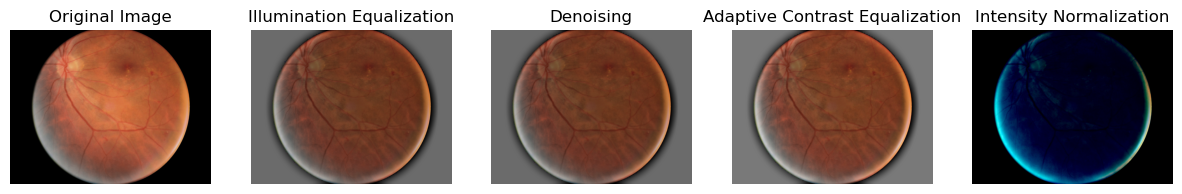

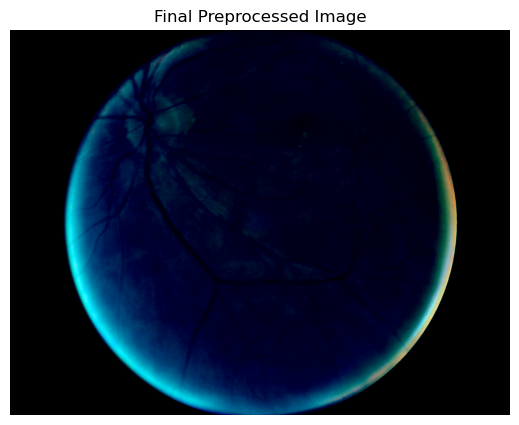

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images(images, titles):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(images[i][..., ::-1] if images[i].ndim == 3 and images[i].shape[2] == 3 else images[i], cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def fundus_roi(image, mask=None):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    threshold = 15
    _, roi = cv2.threshold(v, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(bool)
    white_pixels = np.argwhere(roi == 1)
    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}
    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))
    return {"roi": roi, "diameter": diameter, "image": image}

def mean_filter(channel, kernel_size):
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1
    filtered_channel = cv2.blur(channel, (kernel_size, kernel_size))
    return filtered_channel.astype(np.uint8)

def illumination_equalization(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None. Impossible de continuer.')
        return None
    kernel_size = int(diameter / 10)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_filtered = mean_filter(v, kernel_size)
    mean_v = np.mean(v)
    v_final = cv2.addWeighted(v, 1, v_filtered, -1, mean_v)
    hsv_final = cv2.merge([h, s, v_final])
    image_final = cv2.cvtColor(hsv_final, cv2.COLOR_HSV2BGR)
    return {"image": image_final, "diameter": diameter}

def denoising(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None dans denoising. Impossible de continuer.')
        return None
    kernel_size = int(diameter / 360)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_filtered = mean_filter(v, kernel_size)
    hsv_denoised = cv2.merge([h, s, v_filtered])
    denoising_image = cv2.cvtColor(hsv_denoised, cv2.COLOR_HSV2BGR)
    return {"image": denoising_image, "diameter": diameter}

def adaptive_contrast_equalization(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None dans adaptive_contrast_equalization. Impossible de continuer.')
        return None
    image = image.astype(np.float32) / 255.0
    kernel_size = int(diameter / 10)
    E_x = mean_filter(image, kernel_size)
    E_x2 = mean_filter(image ** 2, kernel_size)
    var = E_x2 - E_x ** 2
    std = np.sqrt(np.maximum(var, 1e-7)) 
    d3 = diameter / 28
    low_pass = mean_filter(image, int(d3))
    high_pass = image - low_pass
    epsilon = 1e-7
    image_final = image + (1 / (std + epsilon)) * high_pass
    image_final = image_final / image_final.max()
    return {"image": (image_final * 255).astype(np.uint8)}

def apply_intensity_normalization(image, diameter=None, roi=None):
    if not isinstance(image, np.ndarray):
        print("Erreur: L'image n'est pas une numpy array valide.")
        return None
    image = image / 255.0  # Normalize image to range [0, 1]
    # Calculate mean and standard deviation for the ROI
    mean = np.mean(image[roi], axis=0, keepdims=True)
    std = np.std(image[roi], axis=0, keepdims=True)

    # Subtract mean
    image_final = image - mean

    # Clipping based on mean and standard deviation
    for i in range(3):  # Iterate over each color channel
        lower_bound = mean[0, i] - 3 * std[0, i]
        upper_bound = mean[0, i] + 3 * std[0, i]
        image_final[:, :, i] = np.clip(image_final[:, :, i], lower_bound, upper_bound)

    # Normalize to range 0-1
    min_val = np.min(image_final, axis=(0, 1), keepdims=True)
    max_val = np.max(image_final, axis=(0, 1), keepdims=True)
    image_final = (image_final - min_val) / (max_val - min_val)

    # Set pixels outside the ROI to 0
    image_final[~roi] = 0

    return {"image": image_final}

def apply_seoud(image):
    images = []
    titles = []

    data = fundus_roi(image)
    images.append(image)
    titles.append("Original Image")
    
    illumination = illumination_equalization(**data)
    if illumination is None:
        print('Erreur lors de l\'égalisation de l\'illumination.')
        return None
    images.append(illumination["image"])
    titles.append("Illumination Equalization")

    denoise = denoising(**illumination)
    if denoise is None:
        print('Erreur lors de la réduction de bruit.')
        return None
    images.append(denoise["image"])
    titles.append("Denoising")

    contrast = adaptive_contrast_equalization(**denoise)
    if contrast is None:
        print('Erreur lors de l\'égalisation de contraste adaptatif.')
        return None
    images.append(contrast["image"])  
    titles.append("Adaptive Contrast Equalization")

    normalized_image = apply_intensity_normalization(**contrast, roi=data["roi"])  
    if normalized_image is None:
        print('Erreur lors de la normalisation de l\'intensité.')
        return None
    images.append(normalized_image["image"])  
    titles.append("Intensity Normalization")

    plot_images(images, titles)
    return normalized_image["image"]

# Chargement de l'image
image = cv2.imread('../data/007-4773-200.jpg')
if image is None:
    print("Erreur: Impossible de charger l'image.")
else:
    image = image.astype(np.uint8)
    seoud_image = apply_seoud(image)
    if seoud_image is not None:
        plot_images([seoud_image], ['Final Preprocessed Image'])
